In [3]:
# from imageProcessing import cut_tif_into_patches_with_hard_boundary

from mmseg.apis import inference_model, init_model, show_result_pyplot
import mmcv
import cv2
import matplotlib.pyplot as plt
import os

import os
from PIL import Image
from tqdm import tqdm

import numpy as np

In [4]:
IMG_PATH = './data/Munich/img_dir'
ANN_PATH = './data/Munich/ann_dir'
# PREDICTED_PATH = '../data/Munich/2023/prediction/samgeo_batches_v3'

IMG_files = os.listdir(IMG_PATH)
IMG_files = list(filter(lambda x: x.endswith(".tif"), IMG_files))
ANN_files = os.listdir(ANN_PATH)
ANN_files = list(filter(lambda x: x.endswith(".png"), ANN_files))

# print(IMG_files)

In [5]:
img = cv2.imread(f'{IMG_PATH}/{IMG_files[0]}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plt.imshow(img)

In [ ]:
def cut_tif_into_patches_with_hard_boundary(i, d, patch_size, ext):
    if not os.path.exists(d):
        os.makedirs(d)

    files = [f for f in os.listdir(i) if f.endswith(ext)]
    for file in tqdm(files, desc='Processing images'):
        file_path = os.path.join(i, file)
        img = Image.open(file_path)
        
        width, height = img.size
        x_patches = width // patch_size
        y_patches = height // patch_size
        
        for x in range(x_patches):
            for y in range(y_patches):
                left = x* patch_size
                upper = y * patch_size
                right = (x+1) * patch_size
                lower = (y+1) * patch_size
                
                patch = img.crop((left, upper, right, lower))
                base, suffix = os.path.splitext(file)
                parts = base.rsplit('_', 1)
                patch_filename = f'{parts[0]}_{x}_{y}_{parts[1]}{suffix}'
                patch.save(os.path.join(d, patch_filename))

# cut_tif_into_patches_with_hard_boundary(i=IMG_PATH, d=f'{IMG_PATH}/patches', patch_size=512)
# cut_tif_into_patches_with_hard_boundary(i=ANN_PATH, d=f'{ANN_PATH}/patches', patch_size=512, ext='.png')

In [14]:
PIMG_PATH = './data/Munich/img_dir/patches'
PANN_PATH = './data/Munich/ann_dir/patches'
PPRED_PATH = './data/Munich/pred_dir/patches'
# PREDICTED_PATH = '../data/Munich/2023/prediction/samgeo_batches_v3'

PIMG_files = os.listdir(PIMG_PATH)
PIMG_files = list(filter(lambda x: x.endswith(".tif"), PIMG_files))
PANN_files = os.listdir(PANN_PATH)
PANN_files = list(filter(lambda x: x.endswith(".png"), PANN_files))
PPRED_files = os.listdir(PPRED_PATH)
PPRED_files = list(filter(lambda x: x.endswith(".tif"), PPRED_files))

# DeepLab V3 ## LoveDa

In [7]:
loveDa_r18_config = r"mmsegmentation\configs\deeplabv3plus\deeplabv3plus_r18-d8_4xb4-80k_loveda-512x512.py"
loveDa_r18_checkpoint = r"checkpoints\DLV3P\deeplabv3plus_r18-d8_512x512_80k_loveda_20211104_132800-ce0fa0ca.pth"

loveDa_r18_model = init_model(loveDa_r18_config, loveDa_r18_checkpoint,cfg_options=dict(classes=('forest'),palette=[[0, 255, 0]]))

c:\Users\henha\miniconda3\envs\openmmlab\Lib\site-packages\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
c:\Users\henha\miniconda3\envs\openmmlab\Lib\site-packages\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: checkpoints\DLV3P\deeplabv3plus_r18-d8_512x512_80k_loveda_20211104_132800-ce0fa0ca.pth


In [8]:
def extract_green(image):
    img = image
    img[:,:,1] = 255
    img[:,:,2] = 255
    # print(g[0,0,:])

    for i in range(len(img[:,0,0])):
        for ii in range(len(img[0,:,0])):
            if img[i, ii, 0] != 255:
                img[i, ii, :] = [0,0,0]
    img = cv2.bitwise_not(img)
    return img

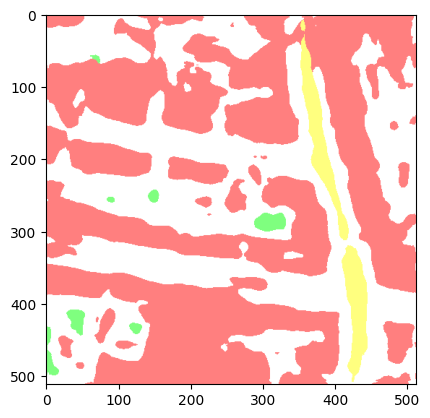

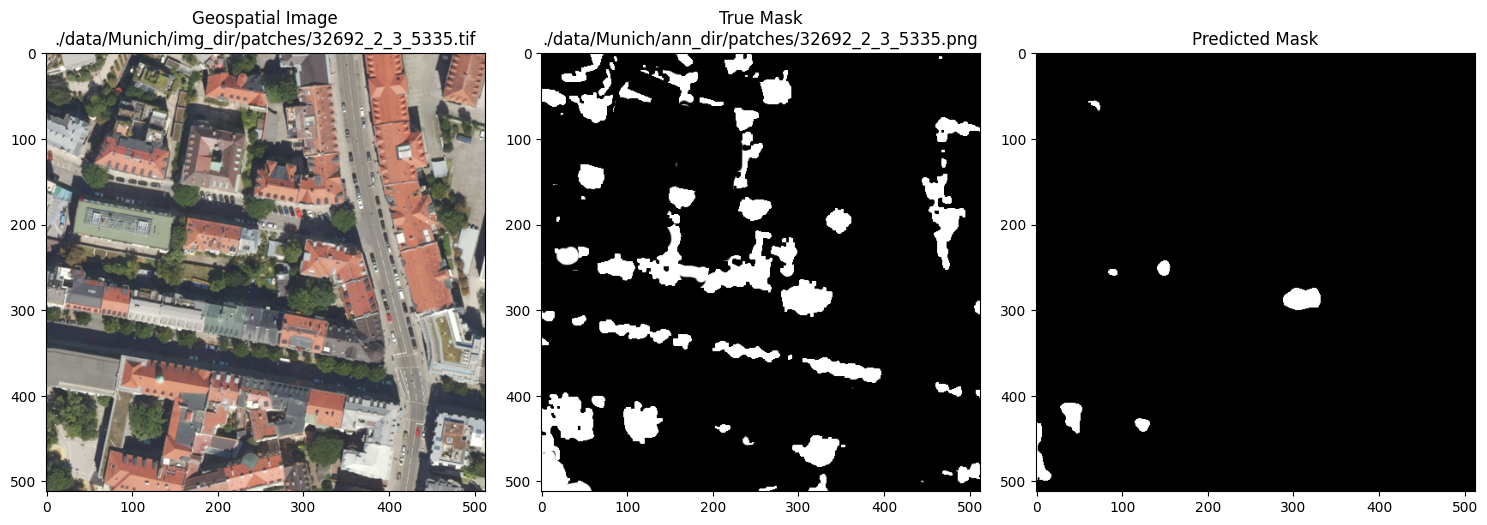

In [15]:
# test a single image and show the results
fileIdx = 70
tIMG = cv2.imread(f'{PIMG_PATH}/{PIMG_files[fileIdx]}')
tIMG = cv2.cvtColor(tIMG, cv2.COLOR_BGR2RGB)
tANN = cv2.imread(f'{PANN_PATH}/{PANN_files[fileIdx]}')
loveDa_r18_im_raw = inference_model(loveDa_r18_model, tIMG)
loveDa_r18_raw_result = show_result_pyplot(loveDa_r18_model, np.full_like(tIMG, [255,255,255]), loveDa_r18_im_raw, with_labels=False)
plt.imshow(loveDa_r18_raw_result)

predicted = extract_green(loveDa_r18_raw_result)
# plt.imshow(predicted)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(tIMG)
plt.title(f'Geospatial Image\n{PIMG_PATH}/{PIMG_files[fileIdx]}')
plt.subplot(1, 3, 2)
plt.imshow(tANN)
plt.title(f'True Mask\n{PANN_PATH}/{PANN_files[fileIdx]}')
plt.subplot(1, 3, 3)
plt.imshow(predicted)
plt.title(f'Predicted Mask')

plt.tight_layout()
plt.show()

In [ ]:
for idx, f in enumerate(PIMG_files):
    fileIdx = idx
    tIMG = cv2.imread(f'{PIMG_PATH}/{PIMG_files[fileIdx]}')
    tIMG = cv2.cvtColor(tIMG, cv2.COLOR_BGR2RGB)
    tANN = cv2.imread(f'{PANN_PATH}/{PANN_files[fileIdx]}')
    loveDa_r18_im_raw = inference_model(loveDa_r18_model, tIMG)
    loveDa_r18_raw_result = show_result_pyplot(loveDa_r18_model, np.full_like(tIMG, [255,255,255]), loveDa_r18_im_raw, with_labels=False)
    # plt.imshow(loveDa_r18_raw_result)

    predicted = extract_green(loveDa_r18_raw_result)
    cv2.imwrite(f'{PPRED_PATH}/{f}', predicted)

In [27]:
import sys
sys.path.append('../mask_evaluation')
from main import print_metrics, evaluate_files, evaluate_file

PANN: ./data/Munich/ann_dir/patches/32692_2_3_5335.png -- PPRED: ./data/Munich/pred_dir/patches/32692_2_3_5335.tif
Results: 
   accuracy: 88.256 %
         f1:  0.154
     recall:  0.084 (or sensitivity)
  precision:  0.952
specificity:  0.999

TPR: 0.084 | FNR: 0.916
TNR: 0.999 | FPR: 0.001
PPV: 0.952 | FDR: 0.048
NPV: 0.882 | FOR: 0.118

ALL MASKS

Results: 
   accuracy: 80.522 %
         f1:  0.717
     recall:  0.562 (or sensitivity)
  precision:  0.991
specificity:  0.996

TPR: 0.562 | FNR: 0.438
TNR: 0.996 | FPR: 0.004
PPV: 0.991 | FDR: 0.009
NPV: 0.743 | FOR: 0.257


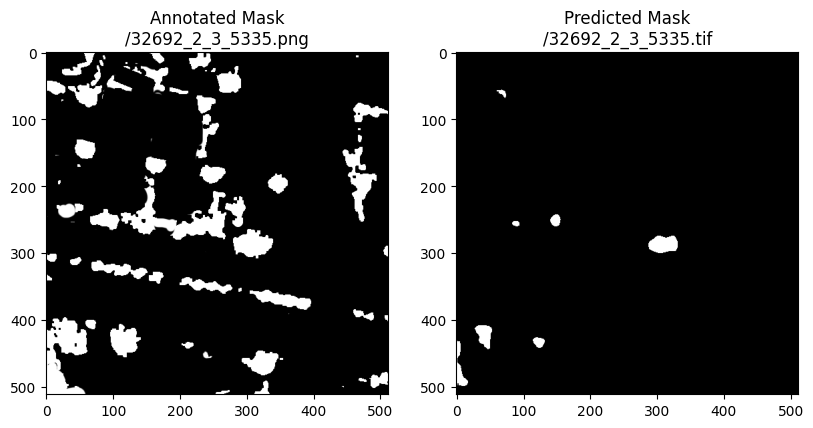

In [32]:
idxx = fileIdx
ev = evaluate_file(f'{PANN_PATH}/{PANN_files[idxx]}', f'{PPRED_PATH}/{PPRED_files[idxx]}')
print(f'PANN: {PANN_PATH}/{PANN_files[idxx]} -- PPRED: {PPRED_PATH}/{PPRED_files[idxx]}')

tPANN = cv2.imread(f'{PANN_PATH}/{PANN_files[fileIdx]}')
tPPRED = cv2.imread(f'{PPRED_PATH}/{PPRED_files[fileIdx]}')

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(tPANN)
plt.title(f'Annotated Mask\n/{PANN_files[fileIdx]}')

plt.subplot(1, 3, 2)
plt.imshow(tPPRED)
plt.title(f'Predicted Mask\n/{PPRED_files[fileIdx]}')

print_metrics(ev)

masks = []
for i in range(len(PPRED_files)-1):
    masks.append((f'{PANN_PATH}/{PANN_files[i]}', f'{PPRED_PATH}/{PPRED_files[i]}'))
evaluation = evaluate_files(masks)
print('\nALL MASKS\n')
print_metrics(evaluation)


26
0.9967603976310527
('./data/Munich/ann_dir/patches/32692_3_2_5347.png', './data/Munich/pred_dir/patches/32692_3_2_5347.tif')
Results: 
   accuracy: 99.354 %
         f1:  0.997
     recall:  0.996 (or sensitivity)
  precision:  0.998
specificity:  0.000

TPR: 0.996 | FNR: 0.004
TNR: 0.000 | FPR: 1.000
PPV: 0.998 | FDR: 0.002
NPV: 0.000 | FOR: 1.000


c:\Users\henha\DeepLearning\dl-areal-image-processing\mmseg\../mask_evaluation\main.py:54: RuntimeWarning: invalid value encountered in scalar divide
  TNR = specificity = counter[TRUE_NEGATIVE] / (counter[TRUE_NEGATIVE] + counter[FALSE_POSITIVE])
c:\Users\henha\DeepLearning\dl-areal-image-processing\mmseg\../mask_evaluation\main.py:55: RuntimeWarning: invalid value encountered in scalar divide
  FPR = independent_of_prevalence = counter[FALSE_POSITIVE] / (counter[TRUE_NEGATIVE] + counter[FALSE_POSITIVE])


Text(0.5, 1.0, 'Predicted Mask\n./data/Munich/pred_dir/patches/32692_3_2_5347.tif')

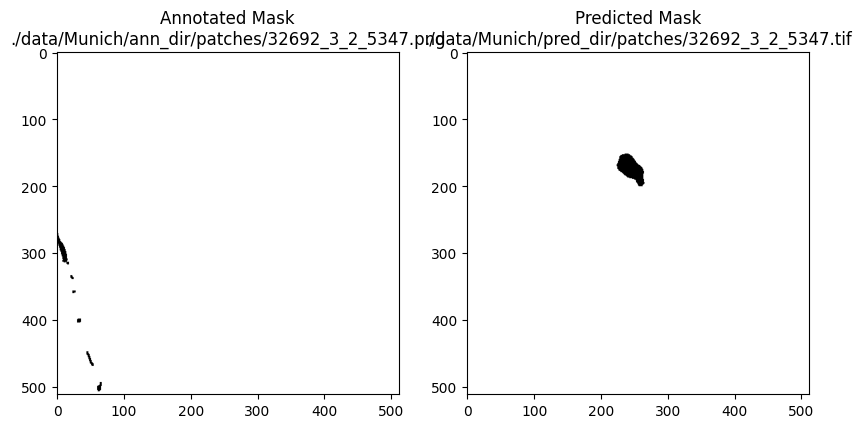

In [35]:
bestf1 = 0
bestmask = ()
bestev = None
for i in range(len(PPRED_files)-1):
    try:
        ev = evaluate_file(f'{PANN_PATH}/{PANN_files[i]}', f'{PPRED_PATH}/{PPRED_files[i]}')
        if(ev.F1 > bestf1):
            bestf1 = ev.F1
            bestmask = (f'{PANN_PATH}/{PANN_files[i]}',f'{PPRED_PATH}/{PIMG_files[i]}')
            bestev = ev
    except:
        print(i)
print(bestf1)
print(bestmask)
print_metrics(bestev)

tPANN = cv2.imread(bestmask[0])
tPPRED = cv2.imread(bestmask[1])

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(tPANN)
plt.title(f'Annotated Mask\n{bestmask[0]}')

plt.subplot(1, 3, 2)
plt.imshow(tPPRED)
plt.title(f'Predicted Mask\n{bestmask[1]}')
